In [1]:
%load_ext lab_black

In [2]:
import os

os.chdir("/cerea_raid/users/dumontj/dev/coco2/inv")
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras
from dataclasses import dataclass, field
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from icecream import ic
import matplotlib_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable
from models.my_efficientnet import EfficientNet
from models.my_essential_inversors import (
    essential_regressor,
    essential_regressor_2,
    essential_regressor_3,
    linear_regressor,
)
from models.my_mobilenet import MobileNet
from models.my_shufflenet import ShuffleNet
from models.my_squeezenet import SqueezeNet
from models.preprocessing import CloudsLayer, ConditionalNoiseLayer

import include.callbacks as callbacks
import include.generators as generators
import include.loss as loss
import include.optimisers as optimisers
import models.seg as sm
from Data import Data_train
from models.preprocessing import CloudsLayer
from saver import Saver
import logging
import sys
from model_training import Trainer

import hydra
import wandb
from omegaconf import DictConfig, OmegaConf

from include.callbacks import initiate_wb
from model_training import Model_training_manager

from typing import List, Optional

matplotlib_functions.setMatplotlibParam()
plt.viridis()
import joblib
import pickle
from include.generators import Generator
from saver import Saver
from include.callbacks import get_modelcheckpoint, ExtraValidation

import model_eval
from Data import Data_train, Data_eval
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger
import models.reg as rm

import hydra
from hydra import initialize, compose
from hydra import compose, initialize
from hydra.utils import call, instantiate
from omegaconf import OmegaConf

2023-12-07 15:56:02.633048: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 15:56:02.633081: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 15:56:02.633128: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 15:56:02.640780: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
wandb: ERROR Unable to patch Tensorflow/Ke

<Figure size 1920x1440 with 0 Axes>

In [3]:
dir_res = "/libre/dumontj/coco2/weights"
name_model = os.path.join(dir_res, "new/inv_lip")
path_train_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/valid_dataset.nc"
path_extra_valid_nc = "/libre/dumontj/coco2/dl-input/2km_Lip/valid_dataset.nc"

In [4]:
model = model_eval.get_inversion_model(
    os.path.join(dir_res, name_model), name_w="w_last.h5"
)

2023-12-07 15:56:11.632545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14570 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


### Train data

In [5]:
data = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model), path_train_nc, model
)

2023-12-07 15:56:18.513184: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [6]:
metrics = model_eval.get_inv_metrics_model_on_data(model, data)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

2023-12-07 15:56:24.818810: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-07 15:56:25.385585: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


786/786 [==============================] - 6s 5ms/step
mae: 14.074817
mape: 159.87793


### Valid data

In [7]:
data = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model), path_valid_nc, model
)

In [8]:
metrics = model_eval.get_inv_metrics_model_on_data(model, data)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

144/144 [==============================] - 1s 5ms/step
mae: 14.418165
mape: 163.9618


### Extra_valid data

In [9]:
data = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model), path_extra_valid_nc, model
)

In [10]:
metrics = model_eval.get_inv_metrics_model_on_data(model, data)
print("mae:", np.mean(metrics["mae"]))
print("mape:", np.mean(metrics["mape"]))

36/36 [==============================] - 0s 5ms/step
mae: 17.085978
mape: 118.7301


## Plot data

In [11]:
num_examples = 5
example_indices = np.random.choice(data.x.eval.shape[0], num_examples, replace=False)

In [12]:
plot_data = data.x.eval

ic| np.sum(plot_data[idx, :, :, 0] == np.min(plot_data[:, :, :, 0])): 2056
ic| np.min(plot_data[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 0] == np.min(plot_data[:, :, :, 0])): 885
ic| np.min(plot_data[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 0] == np.min(plot_data[:, :, :, 0])): 369
ic| np.min(plot_data[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 0] == np.min(plot_data[:, :, :, 0])): 1788
ic| np.min(plot_data[idx, :, :, 0]): -4.5498257
ic| np.sum(plot_data[idx, :, :, 0] == np.min(plot_data[:, :, :, 0])): 150
ic| np.min(plot_data[idx, :, :, 0]): -4.5498257


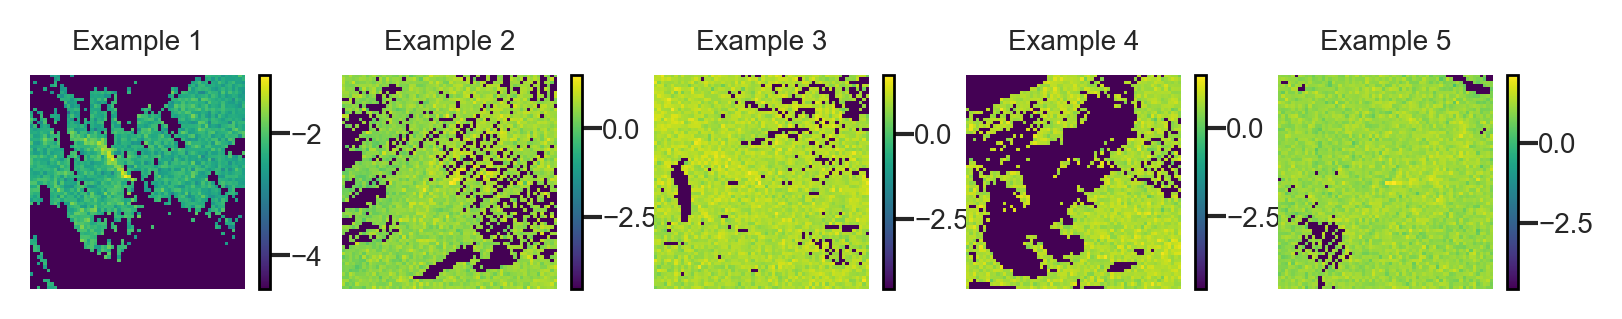

In [13]:
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(plot_data[idx, :, :, 0], cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(plot_data[idx, :, :, 0] == np.min(plot_data[:, :, :, 0])))
    plt.colorbar(im, cax=cax)
    ic(np.min(plot_data[idx, :, :, 0]))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [ ]:
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(data.x.valid[idx, :, :, 3], cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(data.x.valid[idx, :, :, 1] == np.median(data.x.valid[:, :, :, 1])))
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()
ic(np.median(data.x.valid[:, :, :, 1]))

In [ ]:
model_eval.get_summary_histo_inversion(model, data)

nwbce: tf.Tensor(1.4076939, shape=(), dtype=float32)
idx 210
origin: smart_2km_Lip_64
time: 2015-03-06T18:00:00.000000000
emiss: [17.56142 18.57548 19.25024]
nwbce: tf.Tensor(2.9893913, shape=(), dtype=float32)
idx 196
origin: smart_2km_Lip_64
time: 2015-03-06T04:00:00.000000000
emiss: [12.49489 12.15679 13.33856]
nwbce: tf.Tensor(13.575432, shape=(), dtype=float32)
idx 65
origin: smart_2km_Lip_64
time: 2015-01-21T17:00:00.000000000
emiss: [21.14826 22.33432 22.72907]
1/1 [==============================] - 0s 15ms/step


<Figure size 1920x1440 with 0 Axes>

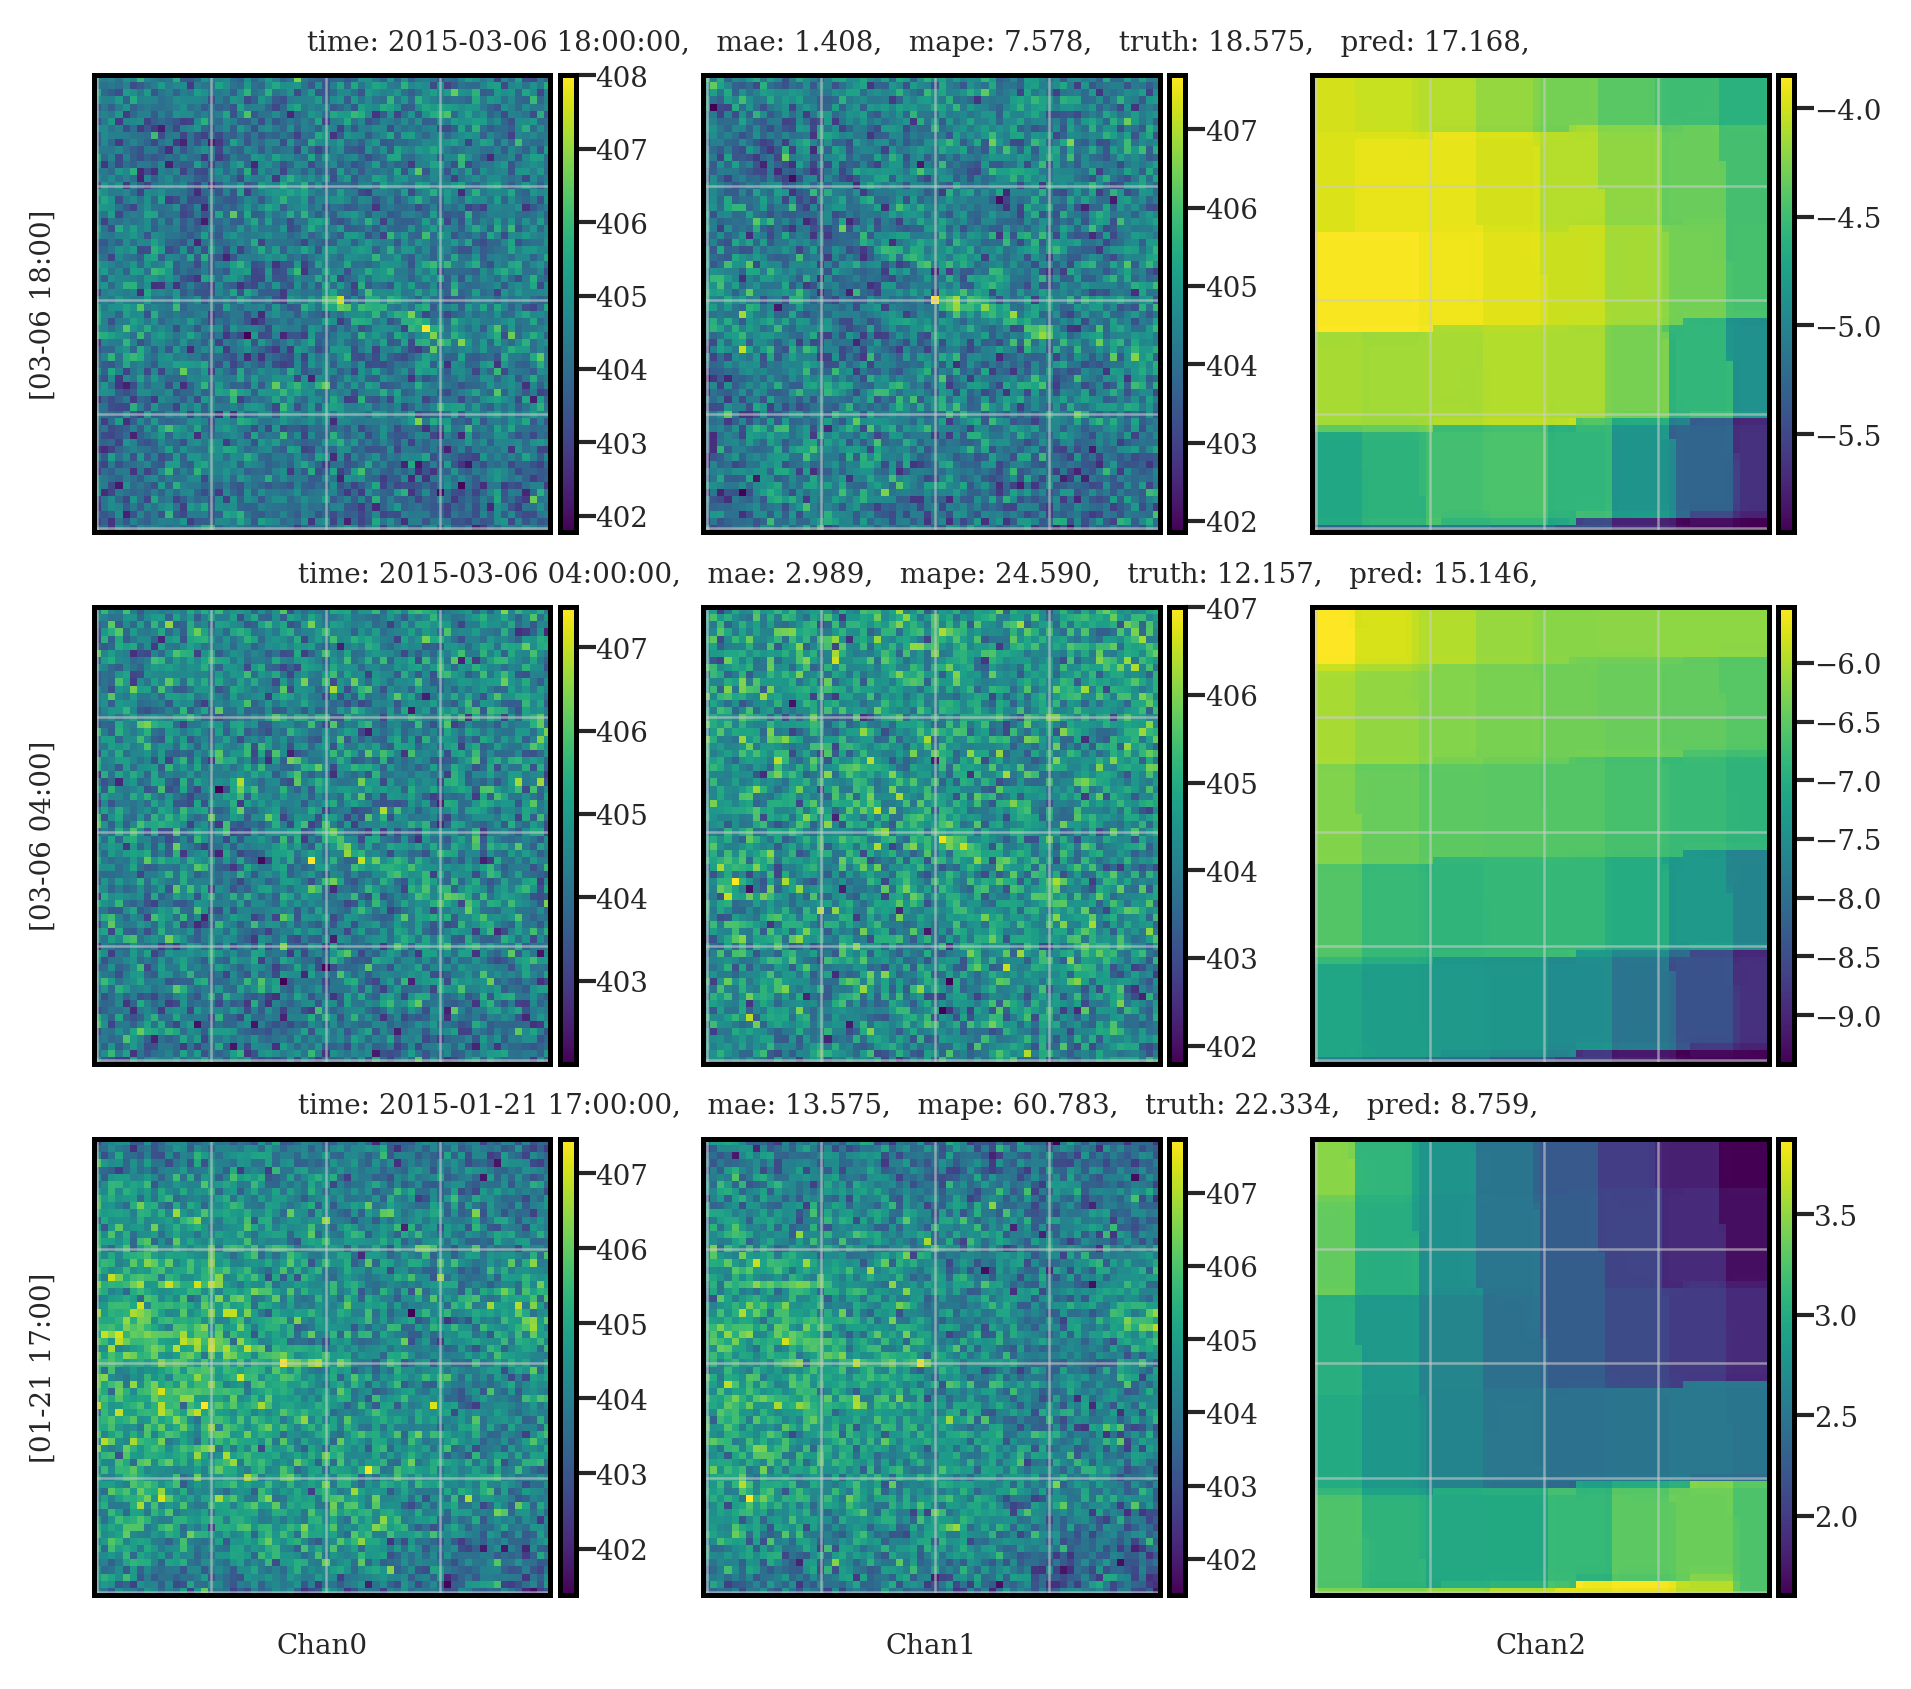

In [23]:
model_eval.plot_inversion_examples(data, metrics["mae"], metrics["mape"], model)

### On validation dataset

In [33]:
data_val = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model),
    path_valid_nc,
)

In [34]:
metrics_val = model_eval.get_inv_metrics_model_on_data(model, data_val)
print("mae:", np.mean(metrics_val["mae"]))
print("mape:", np.mean(metrics_val["mape"]))

144/144 [==============================] - 1s 5ms/step
mae: 3.7455428
mape: 31.967102


144/144 [==============================] - 1s 5ms/step


<Figure size 1920x1440 with 0 Axes>

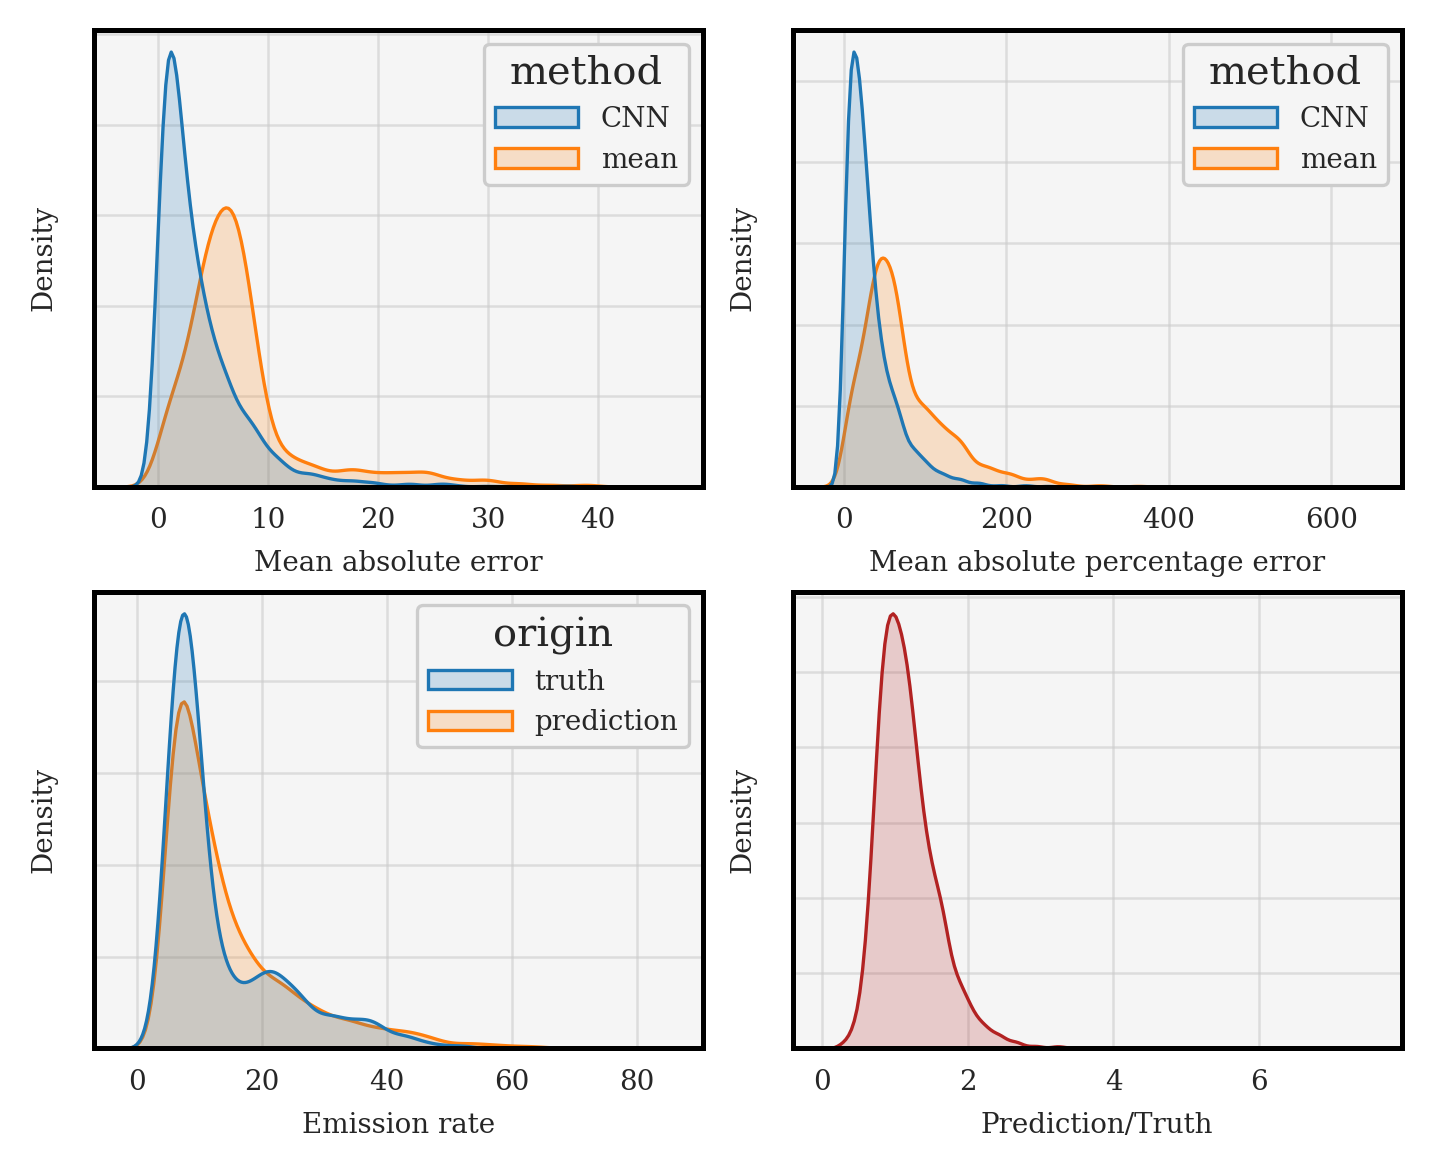

In [35]:
model_eval.get_summary_histo_inversion(model, data_val)

nwbce: tf.Tensor(6.2770367, shape=(), dtype=float32)
idx 3335
origin: smart_2km_Box_64
time: 2015-10-07T23:00:00.000000000
emiss: [17.75714 20.38037 20.58234]
nwbce: tf.Tensor(0.81778526, shape=(), dtype=float32)
idx 572
origin: smart_2km_Ber_64
time: 2015-12-22T17:00:00.000000000
emiss: [25.6846  24.21364 22.95502]
nwbce: tf.Tensor(3.6723938, shape=(), dtype=float32)
idx 3025
origin: smart_2km_Box_64
time: 2015-04-06T03:00:00.000000000
emiss: [14.22674 14.42696 13.44149]
1/1 [==============================] - 0s 15ms/step


<Figure size 1920x1440 with 0 Axes>

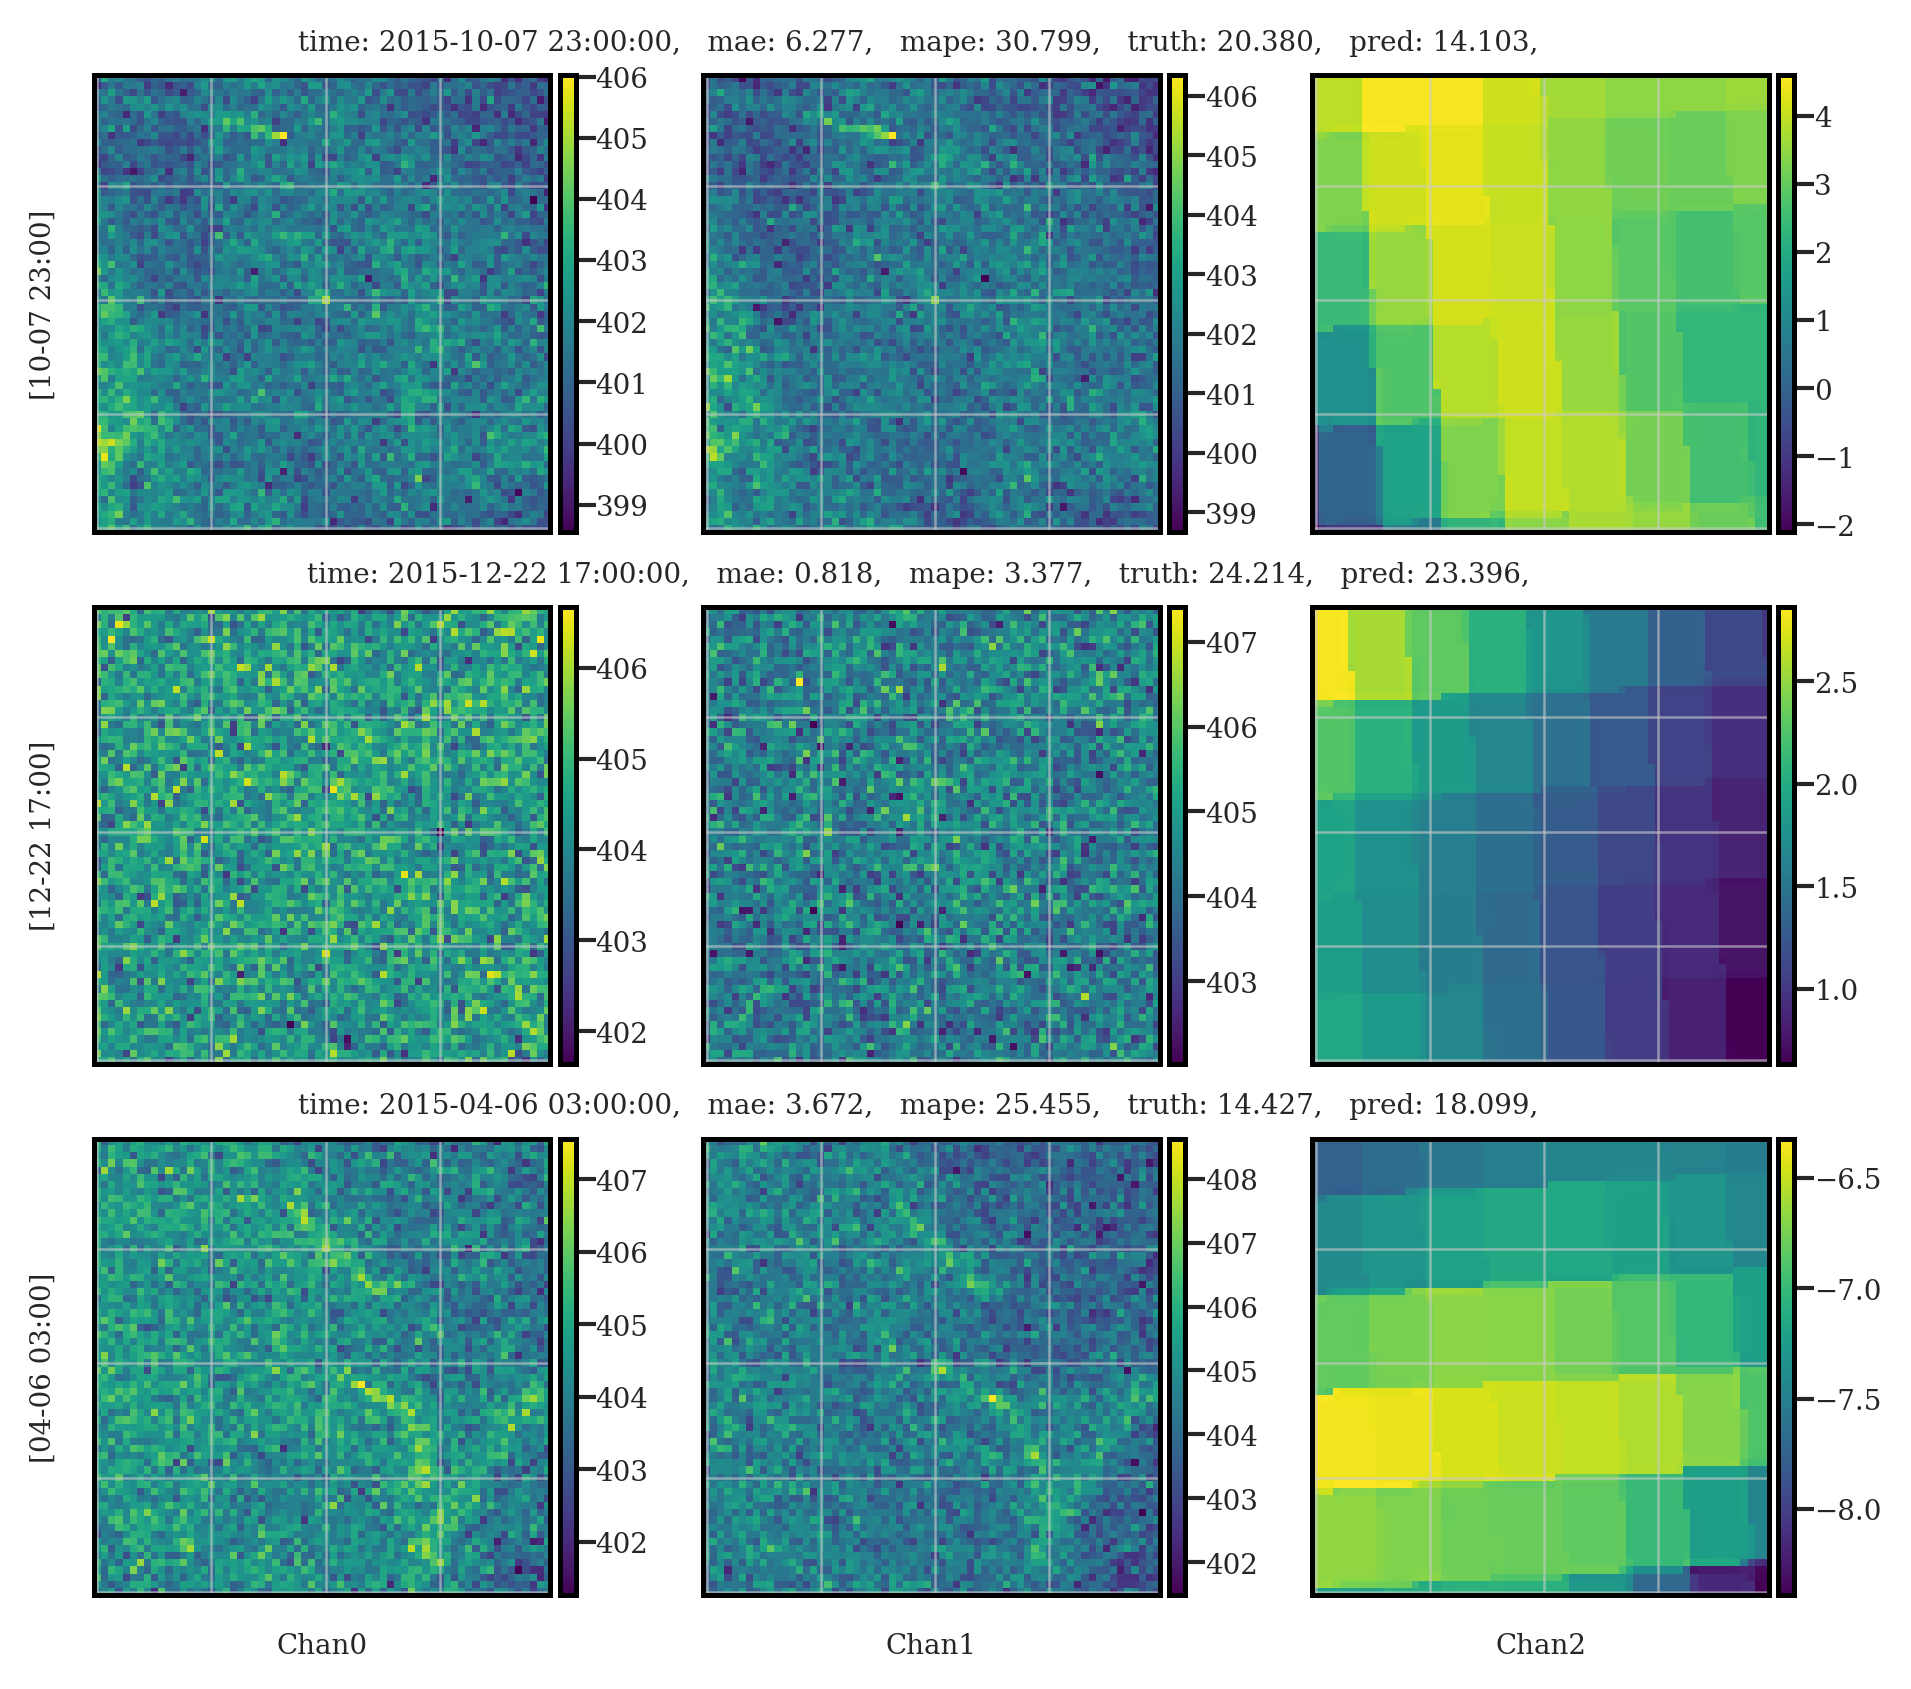

In [36]:
model_eval.plot_inversion_examples(data_val, metrics_val["mae"], metrics_val["mape"], model)

In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 64, 4)]       0         
                                                                 
 conditional_noise_layer_1   (None, 64, 64, 4)         0         
 (ConditionalNoiseLayer)                                         
                                                                 
 preproc_norm (TrainingTime  (None, 64, 64, 4)         9         
 Normalization)                                                  
                                                                 
 clouds_layer_1 (CloudsLaye  (None, 64, 64, 4)         0         
 r)                                                              
                                                                 
 model (Functional)          (None, 576)               186272    
                                                           

In [17]:
cloud_layer = model.get_layer("clouds_layer_1")
norm_layer = model.get_layer("preproc_norm")

In [ ]:
        
        mmap = np.load(self.path_clouds_array, mmap_mode="r")
        clouds_eval = mmap[: self.ds_eval.N_img]
        self.eval = self.cloud_layer.apply_clouds_to_field(
            self.eval, self.list_chans, clouds_eval
        )

In [23]:
array

array([33.11984404, 65.38252543, 62.6800418 ,  4.6577805 ])

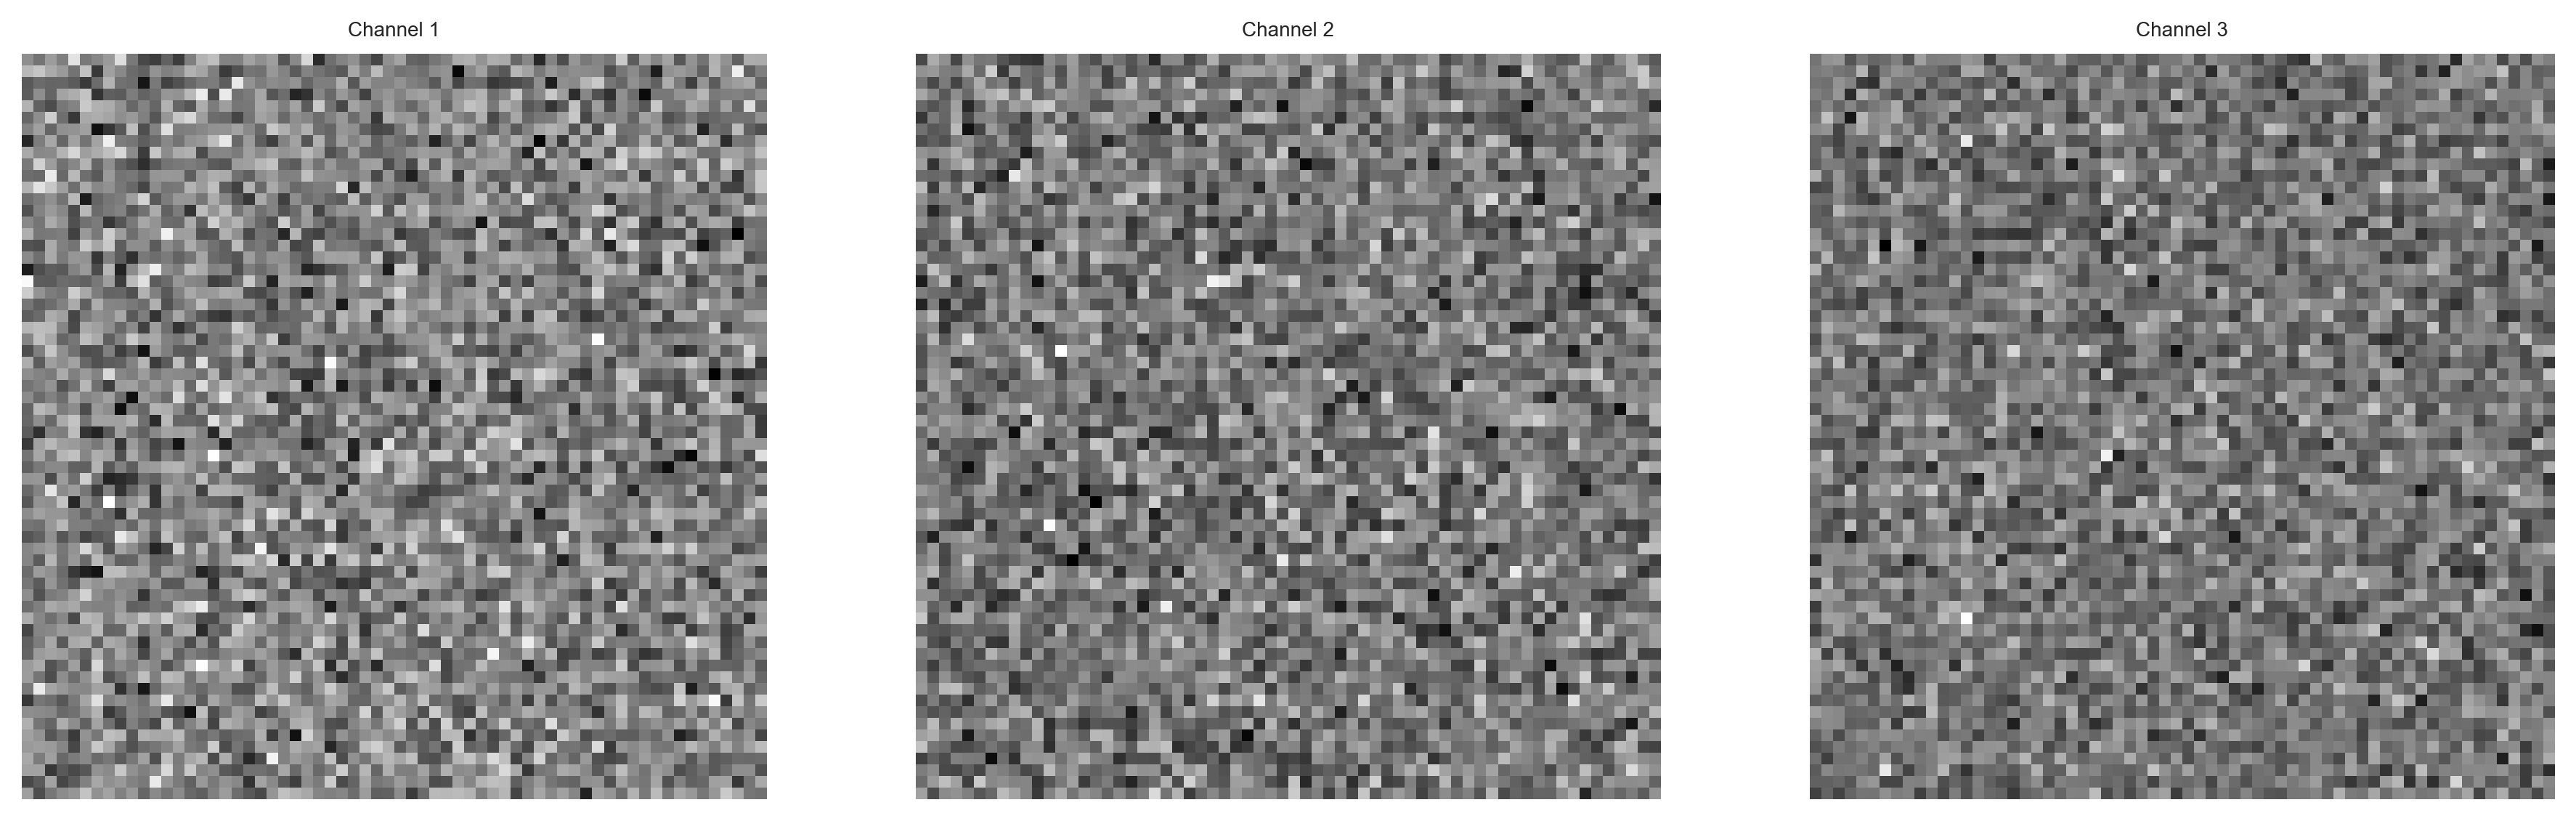

In [31]:
array = np.random.normal(size=(32, 64, 64, 4)) + 400

# Select a random index from the first dimension
random_idx = np.random.randint(0, array.shape[0])

# Plot each channel for the randomly selected index
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].imshow(array[random_idx, :, :, i], cmap="gray")
    axes[i].set_title(f"Channel {i+1}")
    axes[i].axis("off")

plt.show()

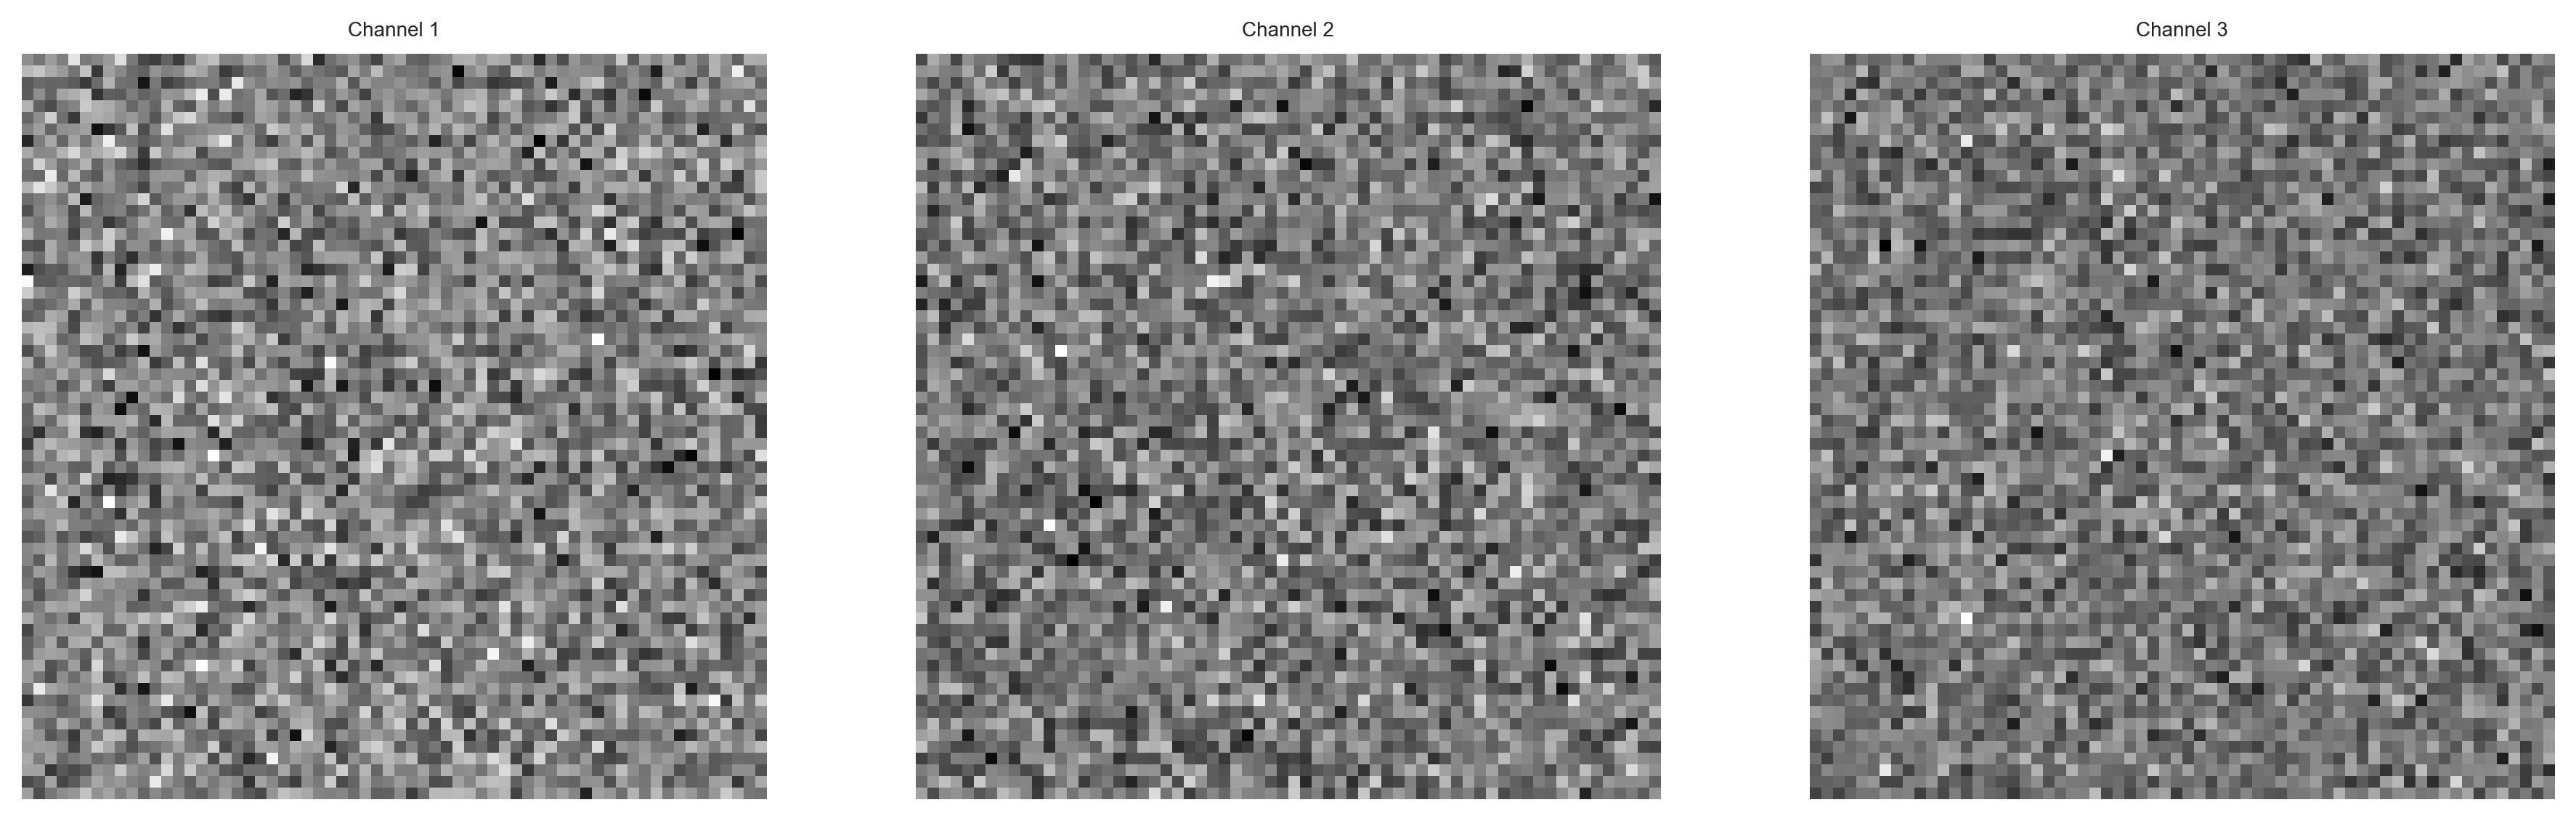

In [32]:
norm_array = np.array(norm_layer(array, training=True))
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].imshow(norm_array[random_idx, :, :, i], cmap="gray")
    axes[i].set_title(f"Channel {i+1}")
    axes[i].axis("off")

plt.show()

# CLOUDS LAYER STUDY

In [5]:
from models.preprocessing import CloudsLayer

In [6]:
clouds_array = np.random.exponential(0.1, (32, 64, 64))
cloudy_chans = ["xco2", "None", "None"]

In [7]:
import numpy as np
import tensorflow as tf

# Create training and evaluation arrays
train_array = np.random.normal(loc=10, scale=1, size=(32, 64, 64, 3))
eval_array = np.random.normal(loc=10, scale=1, size=(32, 64, 64, 3))

In [8]:
cloud_layer = CloudsLayer(clouds_array, cloudy_chans)
cloud_layer.evaluate_nanvalues(train_array)

2023-12-07 11:04:16.093147: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14628 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5


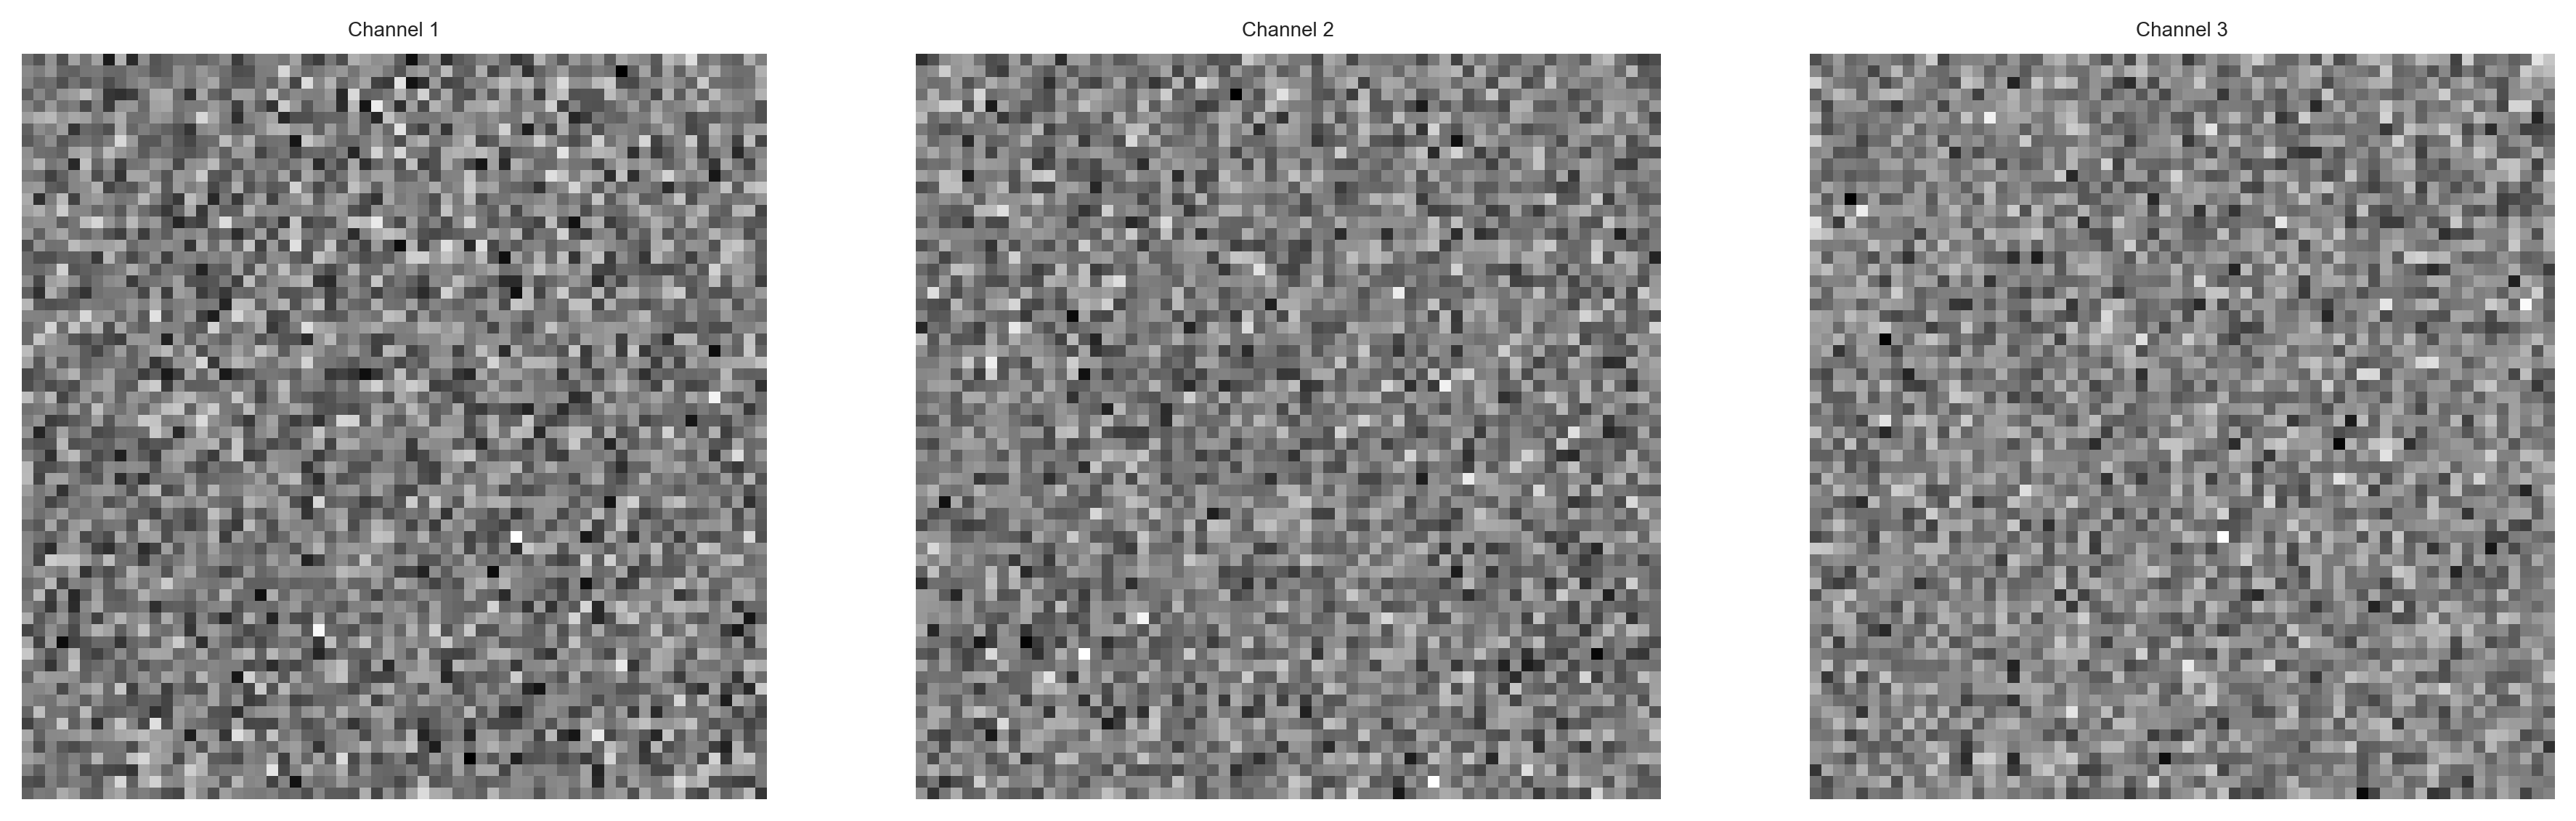

In [9]:
# Select a random index from the first dimension
random_idx = np.random.randint(0, train_array.shape[0])

# Plot each channel for the randomly selected index
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].imshow(train_array[random_idx, :, :, i], cmap="gray")
    axes[i].set_title(f"Channel {i+1}")
    axes[i].axis("off")

plt.show()

2023-12-07 11:04:19.739905: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


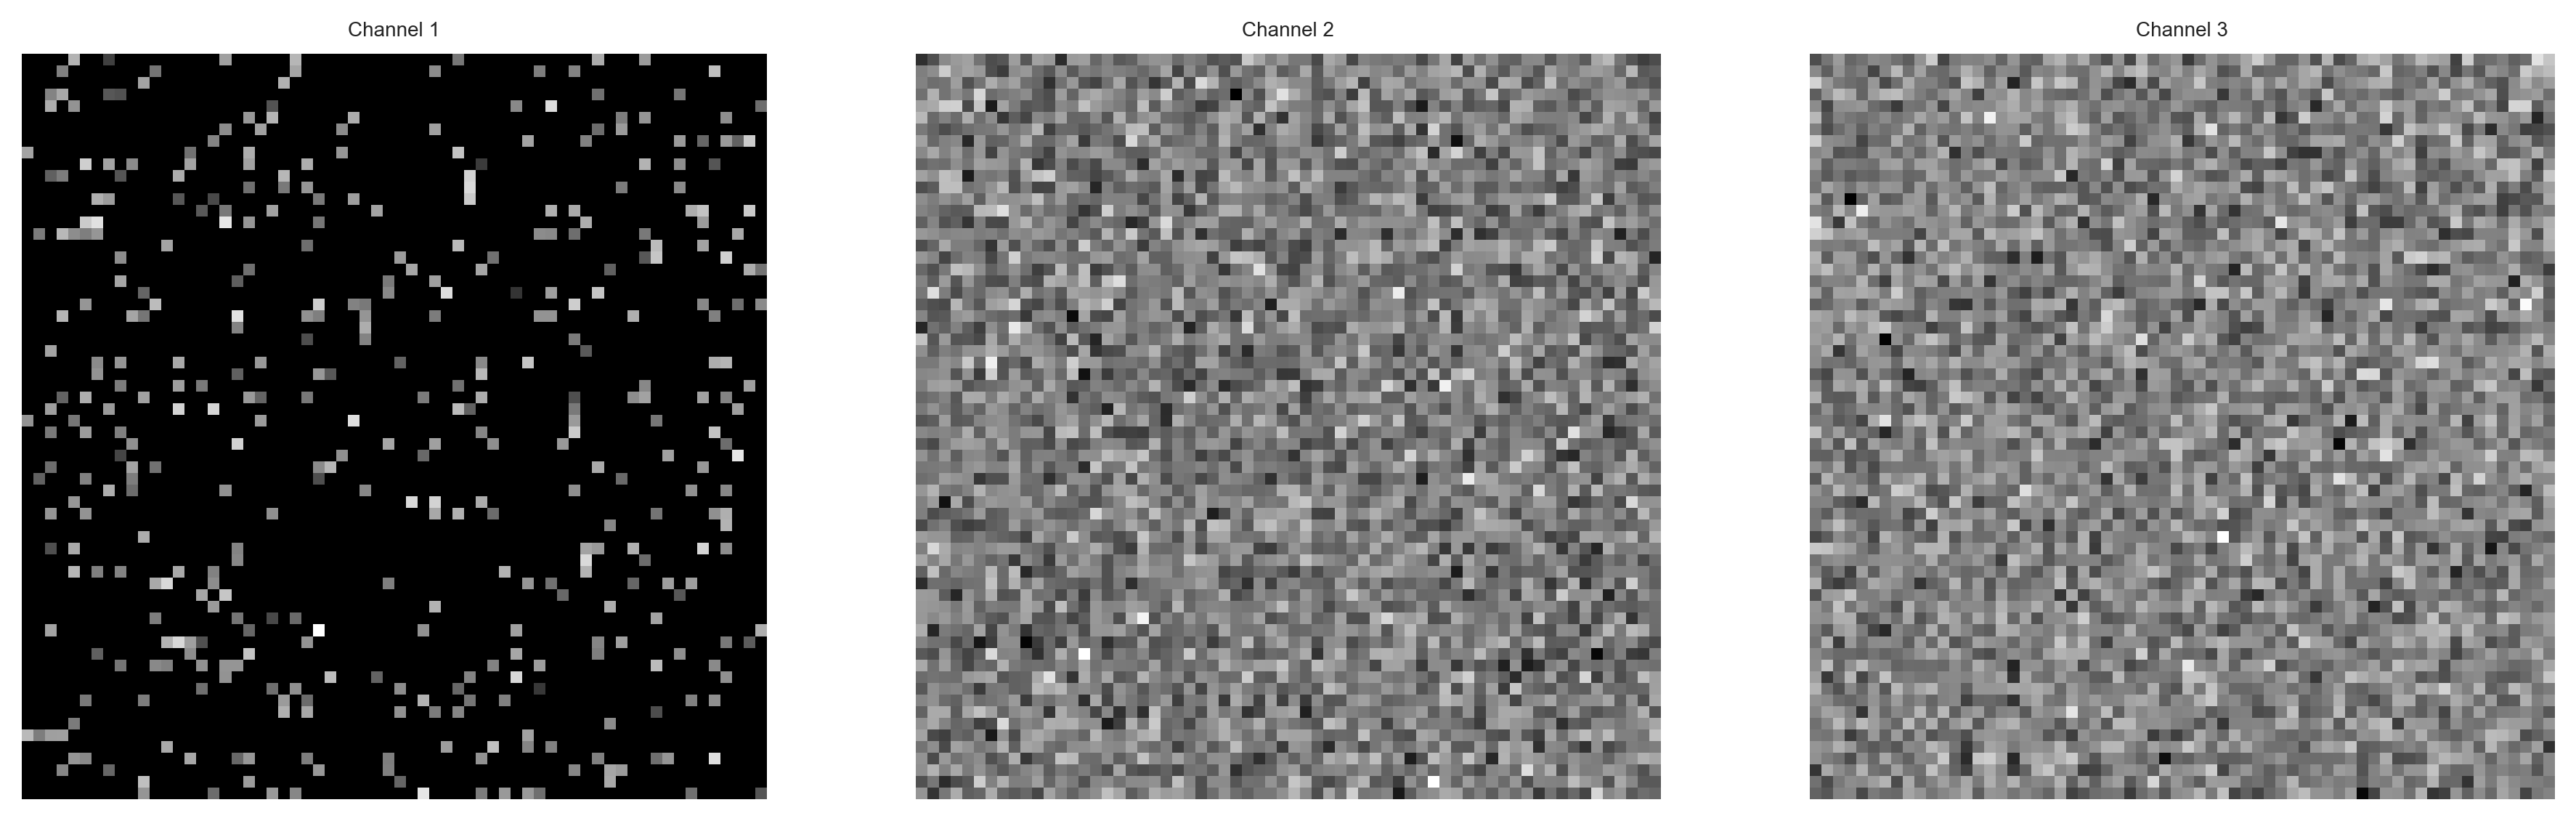

In [10]:
cloud_array = np.array(cloud_layer(train_array, training=True))
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].imshow(cloud_array[random_idx, :, :, i], cmap="gray")
    axes[i].set_title(f"Channel {i+1}")
    axes[i].axis("off")

plt.show()

In [11]:
inputs = tf.keras.Input(shape=(64, 64, 3))
cloudy = cloud_layer(inputs)
model = tf.keras.Model(inputs=inputs, outputs=cloudy)

# Save the entire model
model.save("CloudModel")

INFO:tensorflow:Assets written to: CloudModel/assets


In [12]:
loaded_model = tf.keras.models.load_model(
    "CloudModel",
    custom_objects={"CloudsLayer": CloudsLayer},
)

In [13]:
ic(np.array(loaded_model(eval_array, training=True)).mean())
ic(np.array(loaded_model(eval_array)).mean())

ic| np.array(loaded_model(eval_array, training=True)).mean(): 8.694528
ic| np.array(loaded_model(eval_array)).mean(): 9.999761


9.999761

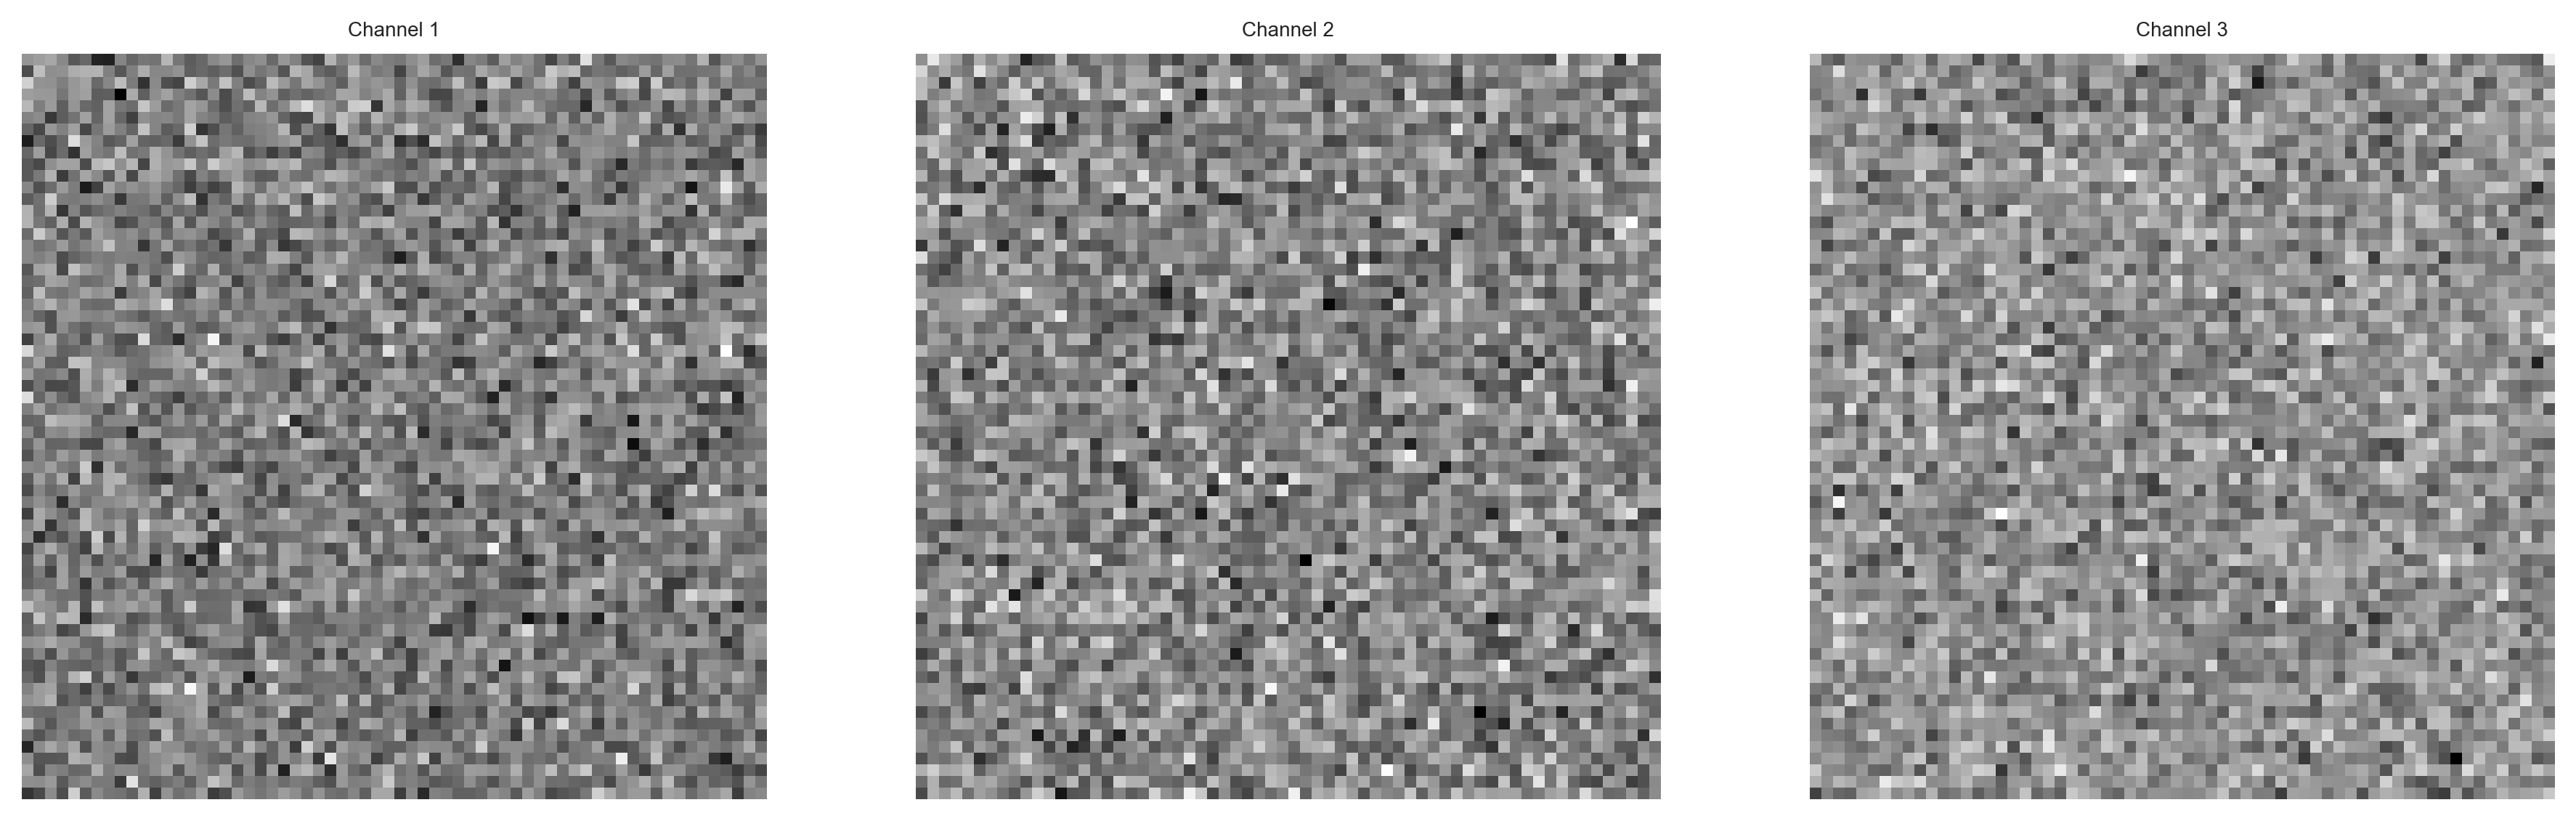

In [14]:
# Select a random index from the first dimension
random_idx = np.random.randint(0, eval_array.shape[0])

# Plot each channel for the randomly selected index
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].imshow(train_array[random_idx, :, :, i], cmap="gray")
    axes[i].set_title(f"Channel {i+1}")
    axes[i].axis("off")

plt.show()

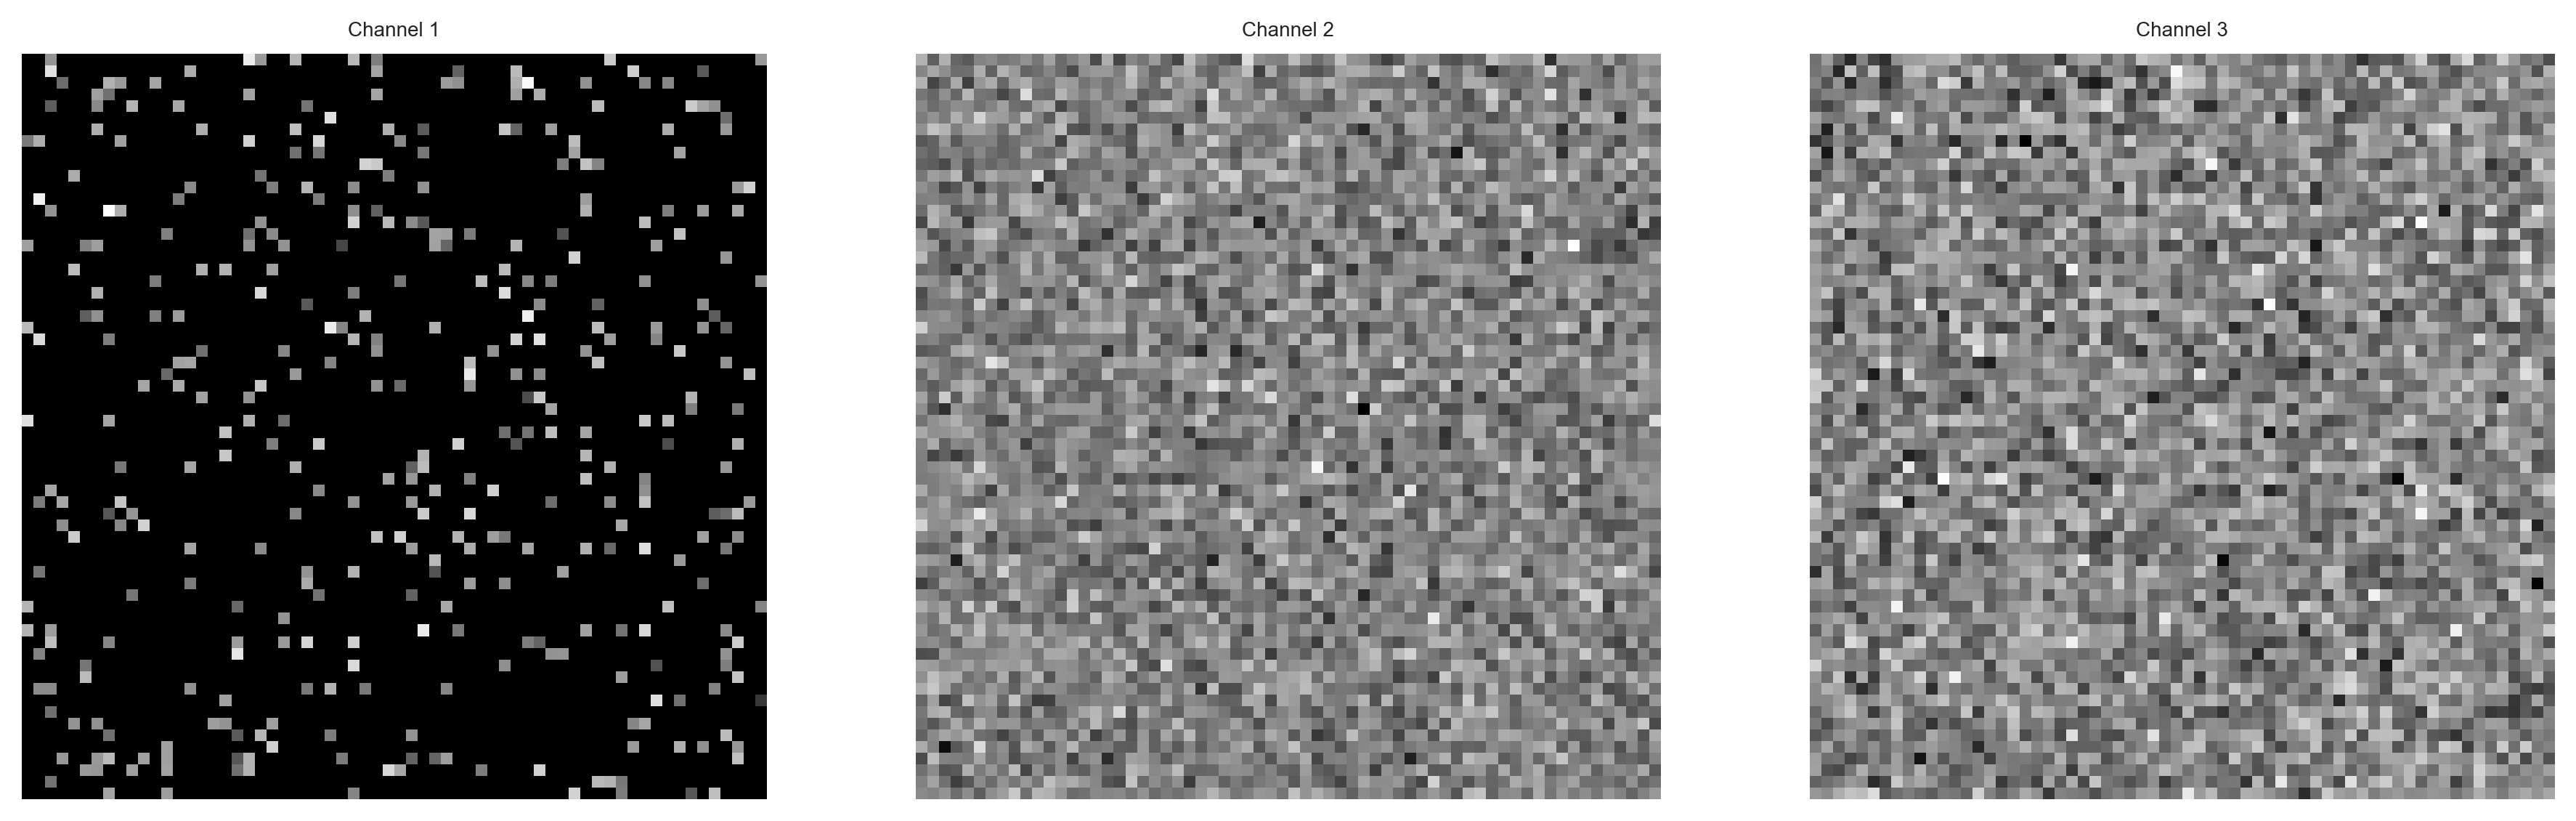

In [15]:
cloud_array = np.array(loaded_model(eval_array, training=True))
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].imshow(cloud_array[random_idx, :, :, i], cmap="gray")
    axes[i].set_title(f"Channel {i+1}")
    axes[i].axis("off")

plt.show()

### model_trainer.data with cfg instantiate

In [4]:
# Compose the configuration
cfg = compose(
    config_name="config",
    overrides=["training.max_epochs=10", "+experiment=inv_lip"],
)

# Print the configuration
print(OmegaConf.to_yaml(cfg))

data:
  init:
    _target_: Data.Data_train
    path_train_ds: ${data.path.directory}/${data.path.train.name}/${data.path.train.nc}
    path_valid_ds: ${data.path.directory}/${data.path.valid.name}/${data.path.valid.nc}
    path_extra_valid_ds: ${data.path.directory}/${data.path.extra_valid.name}/${data.path.extra_valid.nc}
  input:
    dir_seg_models: /cerea_raid/users/dumontj/dev/coco2/dl/res/models
    chan_0: xco2
    chan_1: v_wind
    chan_2: u_wind
    chan_3: no2
    chan_4: None
    clouds: true
    path_clouds_array: /libre/dumontj/coco2/dl-input/clouds/extracted_clouds.npy
  output:
    N_emissions: 1
  path:
    directory: /libre/dumontj/coco2/dl-input
    train:
      name: 2km_forLip_2
      nc: train_dataset.nc
    valid:
      name: 2km_forLip_2
      nc: valid_dataset.nc
    extra_valid:
      name: 2km_Lip
      nc: valid_dataset.nc
dir_res: /libre/dumontj/coco2/weights/new/
exp_name: inv_lip
seed: 42
sweep: true
model:
  type: inversion
  name: essential
  loss_func:

In [5]:
initiate_wb(cfg)

wandb: Currently logged in as: joffreydumont (cerea-daml). Use `wandb login --relogin` to force relogin


In [6]:
from model_training import Model_training_manager

In [7]:
model_trainer = Model_training_manager(cfg)

/libre/dumontj/coco2/dl-input/2km_forLip_2/train_dataset.nc


2023-12-07 13:27:53.493171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14630 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5
2023-12-07 13:27:59.076557: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
ic| self.train.shape: (25152, 64, 64, 4)
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [9]:
inputs = tf.keras.Input(shape=(64, 64, 4))
cloudy = model_trainer.data.x.cloud_layer(inputs)
model = tf.keras.Model(inputs=inputs, outputs=cloudy)

# Save the entire model
model.save("CloudModel")

INFO:tensorflow:Assets written to: CloudModel/assets


In [10]:
loaded_model = tf.keras.models.load_model(
    "CloudModel",
    custom_objects={"CloudsLayer": CloudsLayer},
)

In [16]:
cloud_layer = loaded_model.get_layer("cloud_layer")

In [18]:
cloud_layer.clouds_array

ListWrapper([])

In [ ]:
model_trainer.data.x.valid

In [20]:
ic(np.array(model_trainer.data.x.valid).mean())
ic(np.array(loaded_model(model_trainer.data.x.valid)).mean())

ic| np.array(model_trainer.data.x.valid).mean(): -0.3690194
ic| np.array(loaded_model(model_trainer.data.x.valid)).mean(): -0.3690194


-0.3690194

In [ ]:
apply_clouds_to_field(

In [12]:
ic(np.array(loaded_model(model_trainer.data.x.valid, training=True)).mean())
ic(np.array(loaded_model(model_trainer.data.x.valid)).mean())

AttributeError: Exception encountered when calling layer 'cloud_layer' (type CloudsLayer).

'ListWrapper' object has no attribute 'shape'

Call arguments received by layer 'cloud_layer' (type CloudsLayer):
  • inputs=tf.Tensor(shape=(4608, 64, 64, 4), dtype=float32)
  • training=True
  • kwargs=<class 'inspect._empty'>

### model_trainer.data with regular ic

In [77]:
class Model_training_manager:
    """Manager for segmentation, inversion with CNN models."""

    def __init__(self, cfg: DictConfig) -> None:
        self.prepare_data(cfg)

        inputs = tf.keras.Input(shape=(64, 64, 4))
        cloudy = self.data.x.cloud_layer(inputs)
        model = tf.keras.Model(inputs=inputs, outputs=cloudy)

        self.build_model(cfg)

        inputs = tf.keras.Input(shape=(64, 64, 4))
        cloudy = self.data.x.cloud_layer(inputs)
        model = tf.keras.Model(inputs=inputs, outputs=cloudy)

        self.prepare_training(cfg)

        inputs = tf.keras.Input(shape=(64, 64, 4))
        cloudy = self.data.x.cloud_layer(inputs)
        model = tf.keras.Model(inputs=inputs, outputs=cloudy)

        self.saver = Saver()

    def prepare_data(self, cfg: DictConfig) -> None:
        """Prepare Data inputs to the neural network and outputs (=labels, targets)."""

        print(cfg.data.init.path_train_ds)
        self.data = instantiate(cfg.data.init)

        if cfg.model.type == "inversion":
            self.data.prepare_input(
                cfg.data.input.chan_0,
                cfg.data.input.chan_1,
                cfg.data.input.chan_2,
                cfg.data.input.chan_3,
                cfg.data.input.chan_4,
                cfg.data.input.clouds,
                cfg.data.input.path_clouds_array,
                cfg.data.input.dir_seg_models,
            )
            self.data.prepare_output_inversion(cfg.data.output.N_emissions)

    def build_model(self, cfg: DictConfig) -> None:
        """Build the inversion or segmentation model."""

        if "load_weights" in cfg:
            self.model = tf.keras.models.load_model(
                os.path.join(cfg.dir_res, cfg.load_weights, "weights_cp_best.h5"),
                compile=True,
            )

        else:
            if cfg.model.type == "inversion":
                reg_builder = rm.Reg_model_builder(
                    cfg.model.name,
                    self.data.x.fields_input_shape,
                    self.data.y.classes,
                    self.data.x.norm_layer,
                    self.data.x.noise_layer,
                    cfg.model.dropout_rate,
                    cfg.model.scaling_coefficient,
                    self.data.x.cloud_layer,
                    self.data.x.cloud_bool,
                )
                self.model = reg_builder.get_model()

            else:
                sys.exit()

            self.model.compile(
                optimizer=optimisers.define_optimiser(
                    cfg.training.optimiser, cfg.training.learning_rate
                ),
                loss=loss.define_loss(cfg.model.loss_func),
                metrics=loss.define_metrics(cfg.model.type),
            )

    def prepare_training(self, cfg: DictConfig) -> None:
        """Prepare the training phase."""

        if cfg.model.type == "inversion":
            generator = generators.ScaleDataGen(
                self.data.x.train,
                self.data.x.plumes_train,
                self.data.x.xco2_back_train,
                self.data.x.xco2_alt_anthro_train,
                self.data.y.train,
                self.data.x.scale_bool,
                self.data.x.fields_input_shape,
                plume_scaling_min=cfg.augmentations.plume_scaling_min,
                plume_scaling_max=cfg.augmentations.plume_scaling_max,
            )
        else:
            logging.error("Error")
            sys.exit()
        cbs = callbacks.get_modelcheckpoint(cfg.callbacks.model_checkpoint, [])
        cbs = callbacks.get_lrscheduler(cfg.callbacks.learning_rate_monitor, cbs)
        cbs = callbacks.get_wandb(cfg.callbacks.wandb, cbs)

        history = callbacks.ExtraValidation(
            (self.data.x.extra_valid, self.data.y.extra_valid)
        )
        cbs.append(WandbMetricsLogger())
        cbs.append(history)

        self.trainer = Trainer(
            generator,
            cbs,
            cfg.training.batch_size,
            cfg.training.max_epochs,
        )

    def run(self) -> None:
        """Train the model with the training data."""
        self.model = self.trainer.train_model(self.model, self.data)
        return self.trainer.get_val_loss()

    def save(self) -> None:
        """Save results of the run."""
        print("Saving at:", os.getcwd())
        self.saver.save_model_and_weights(self.model)

In [78]:
model_trainer = Model_training_manager(cfg)

/libre/dumontj/coco2/dl-input/2km_forLip_2/train_dataset.nc


ic| self.train.shape: (25152, 64, 64, 4)


In [80]:
inputs = tf.keras.Input(shape=(64, 64, 4))
cloudy = model_trainer.data.x.cloud_layer(inputs)
model = tf.keras.Model(inputs=inputs, outputs=cloudy)

### Other 

In [46]:
class CloudsLayer(tf.keras.layers.Layer):
    """Specific layer to add clouds to images only at training."""

    def __init__(
        self, clouds_array=[], cloudy_chans=[], nanmin=[], nanmedian=[], **kwargs
    ):
        super().__init__(**kwargs)
        self.clouds_array = clouds_array
        self.cloudy_chans = cloudy_chans
        self.eval_clouds_array = None
        self.nanmin = nanmin
        self.nanmedian = nanmedian

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "cloudy_chans": self.cloudy_chans,
                "nanmin": self.nanmin.numpy().tolist(),
                "nanmedian": self.nanmedian.numpy().tolist(),
            }
        )
        return config

    def apply_clouds_to_field(self, field, cloudy_chans: list, clouds):
        """Apply clouds to field given list_chans."""
        list_tensor = [None] * len(cloudy_chans)
        for idx, chan_name in enumerate(cloudy_chans):
            if chan_name in ["xco2", "no2"]:
                threshold = 0.01 if chan_name == "xco2" else 0.3
                bin_threshold = tf.cast(clouds < threshold, dtype=field.dtype)
                channel_data = field[:, :, :, idx]
                modified_channel_data = tf.where(
                    bin_threshold == 0,
                    tf.constant(np.nan, dtype=channel_data.dtype),
                    channel_data,
                )

                # Determine the appropriate numpy function based on chan_name
                nan_val = self.nanmin if chan_name == "xco2" else self.nanmedian

                # Apply the function and replace NaNs in the new tensor
                list_tensor[idx] = tf.where(
                    tf.math.is_nan(modified_channel_data),
                    tf.fill(
                        tf.shape(modified_channel_data),
                        nan_val[idx],
                    ),
                    modified_channel_data,
                )
            else:
                list_tensor[idx] = field[:, :, :, idx]
        new_field = tf.stack(list_tensor, axis=-1)
        return new_field

    def evaluate_nanvalues(self, train_data):
        """Evaluate nan min and nan median values on train_data."""
        nanmin_np = np.nanmin(train_data, axis=(0, 1, 2))
        nanmedian_np = np.nanmedian(train_data, axis=(0, 1, 2))
        self.nanmin = tf.convert_to_tensor(nanmin_np, dtype=tf.float32)
        self.nanmedian = tf.convert_to_tensor(nanmedian_np, dtype=tf.float32)

    def call(self, inputs, training=None, **kwargs):
        # Assuming inputs and clouds_array are compatible for element-wise multiplication
        # Randomly select indices from clouds_array
        if training:
            random_indices = np.random.choice(
                self.clouds_array.shape[0], size=inputs.shape[0], replace=True
            )
            selected_clouds = self.clouds_array[random_indices]
            clouded_fields = self.apply_clouds_to_field(
                inputs, self.cloudy_chans, selected_clouds
            )

            return clouded_fields
        else:
            return inputs

In [52]:
cloud_layer = CloudsLayer(clouds_array, cloudy_chans)
cloud_layer.evaluate_nanvalues(train_array)
cloud_layer

In [53]:
data.x.cloud_layer

In [42]:
clouds_array = np.random.exponential(0.1, (32, 64, 64))
cloudy_chans = ["xco2", "None", "None"]

In [43]:
inputs = tf.keras.Input(shape=(64, 64, 4))
cloudy = data(inputs)
model = tf.keras.Model(inputs=inputs, outputs=cloudy)

# Save the entire model
# model.save("CloudModel")

In [45]:
data.x.cloud_layer(inputs)

TypeError: Binding inputs to tf.function failed due to `missing a required argument: 'inputs'`. Received args: (<tf.Tensor 'Placeholder:0' shape=(None, 64, 64, 4) dtype=float32>,) and kwargs: {'training': False} for signature: (self, inputs, training=<object object at 0x7f22beccc0a0>, **kwargs).

In [49]:
mmap = np.load(cfg.data.input.path_clouds_array, mmap_mode="r")
data.x.clouds_training = np.array(
    mmap[data.x.ds_valid.N_img + data.x.ds_extra_valid.N_img :]
)
cloud_layer_2 = CloudsLayer(
    data.x.clouds_training, data.x.cloudy_chans, name="cloud_layer"
)
cloud_layer_2.evaluate_nanvalues(data.x.norm_layer(data.x.train, training=True))

In [50]:
inputs = tf.keras.Input(shape=(64, 64, 4))
cloudy = cloud_layer_2(inputs)
model = tf.keras.Model(inputs=inputs, outputs=cloudy)

In [51]:
cloud_layer_2

In [56]:
data = instantiate(cfg.data.init)

if cfg.model.type == "inversion":
    data.prepare_input(
        cfg.data.input.chan_0,
        cfg.data.input.chan_1,
        cfg.data.input.chan_2,
        cfg.data.input.chan_3,
        cfg.data.input.chan_4,
        cfg.data.input.clouds,
        cfg.data.input.path_clouds_array,
        cfg.data.input.dir_seg_models,
    )
    data.prepare_output_inversion(cfg.data.output.N_emissions)

ic| self.train.shape: (25152, 64, 64, 4)


In [71]:
a = data.x.cloud_layer(inputs=train_array)

inputs = tf.keras.Input(shape=(64, 64, 4))
cloudy = data.x.cloud_layer(inputs)
model = tf.keras.Model(inputs=inputs, outputs=cloudy)

In [70]:
reg_builder = rm.Reg_model_builder(
    cfg.model.name,
    data.x.fields_input_shape,
    data.y.classes,
    data.x.norm_layer,
    data.x.noise_layer,
    cfg.model.dropout_rate,
    cfg.model.scaling_coefficient,
    data.x.cloud_layer,
    data.x.cloud_bool,
)
model = reg_builder.get_model()

model.compile(
    optimizer=optimisers.define_optimiser(
        cfg.training.optimiser, cfg.training.learning_rate
    ),
    loss=loss.define_loss(cfg.model.loss_func),
    metrics=loss.define_metrics(cfg.model.type),
)